In [1]:
import FinanceDataReader as fdr
import pandas_datareader as pdr
import pymysql
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import pytz
import requests
from bs4 import BeautifulSoup
import re
from dateutil.relativedelta import relativedelta
import sys
import pymysql
import time
from matplotlib import pyplot as plt
import seaborn
import math
fdr.__version__

'0.9.1'

In [2]:
### 원유 가격과 주식 시장의 추이를 살펴본다.

In [3]:
#데이터베이스 연결
connection = pymysql.connect(host='localhost',
                             user='investment',
                             password='1111',
                             db='investment',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)


with connection.cursor() as cursor:
    sql = '''SELECT record_date, oil_dbi_price, kospi_price, nasdaq_price, usd_krw_price
                FROM dailyfinancedata D;'''
    cursor.execute(sql)
    data = cursor.fetchall()

connection.close()    
df = pd.DataFrame(data)

In [4]:
df['oil_dbi_price'] = df['oil_dbi_price'].astype(float)
df['kospi_price'] = df['kospi_price'].astype(float)
df['nasdaq_price'] = df['nasdaq_price'].astype(float)
df['usd_krw_price']= df['usd_krw_price'].astype(float)
df['oil_dbi_price_'] = df['oil_dbi_price'] * 30
df_krw = pd.DataFrame(df.loc[:,'usd_krw_price'])

df = df.set_index('record_date')
df.index = pd.to_datetime(df.index)
df_kospi = pd.DataFrame(df.loc[:,'kospi_price'])
df_nasdaq = pd.DataFrame(df.loc[:,'nasdaq_price'])
df_oil = pd.DataFrame(df.loc[:,'oil_dbi_price'])

df_kospi = df_kospi[np.isfinite(df_kospi['kospi_price'])]
df_oil = df_oil[np.isfinite(df_oil['oil_dbi_price'])]
df_nasdaq = df_nasdaq[np.isfinite(df_nasdaq['nasdaq_price'])]
df_krw = df_krw[np.isfinite(df_krw['usd_krw_price'])]

df.head()

,oil_dbi_price,kospi_price,nasdaq_price,usd_krw_price,oil_dbi_price_
record_date,,,,,
1980-03-18,NaN,NaN,138.92,NaN,NaN
1980-03-19,NaN,NaN,139.97,NaN,NaN
1980-03-20,NaN,NaN,139.64,NaN,NaN
1980-03-21,NaN,NaN,138.80,NaN,NaN
1980-03-22,NaN,NaN,NaN,NaN,NaN


In [5]:
def plot(df, column_names=[], year=[], fig_size = (40,10), lines = [], normalize = False, minmax = False):
    
    
    df_plot = pd.DataFrame(df.loc[:, column_names])
    df_plot = df_plot[df_plot.notna()]
    df_plot = df_plot[df_plot.index.year.isin(year)]
    
    if(normalize == True):
        df_plot=(df_plot-df_plot.mean())/df_plot.std()
    if(minmax == True):    
        df_plot=(df_plot-df_plot.min())/(df_plot.max()-df_plot.min())
    
    df_plot.plot()
    plt.rcParams["figure.figsize"] = fig_size
    
    for line in lines:
        plt.axhline(y=line, color='r', linestyle='-')
    plt.show()
    #print(df_plot.head())
    #return df_plot
    
    

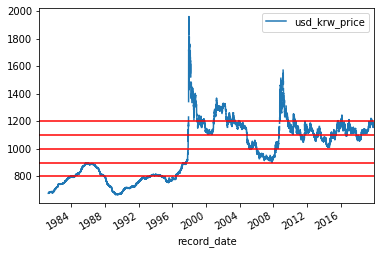

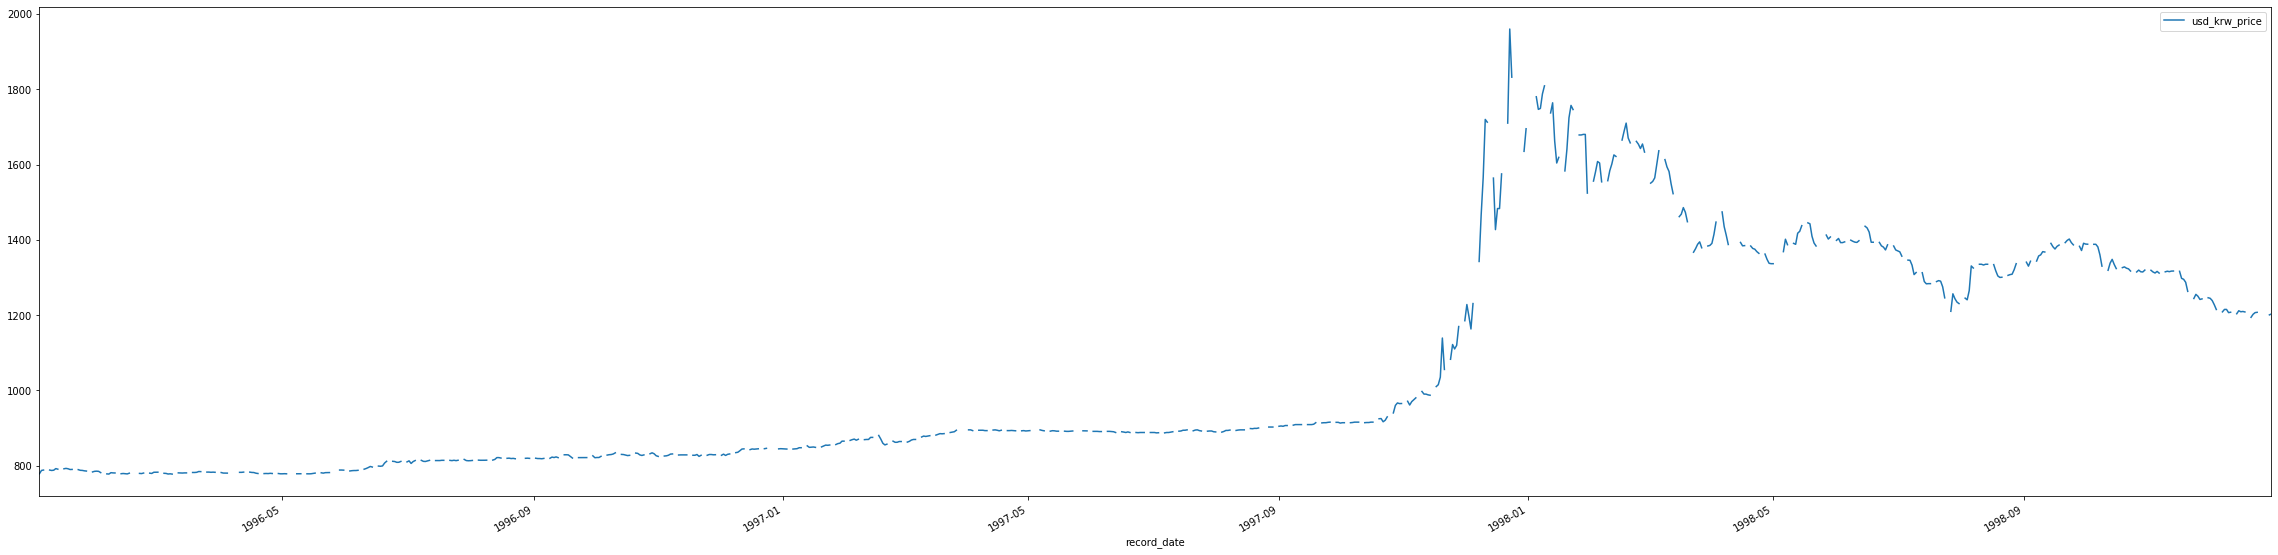

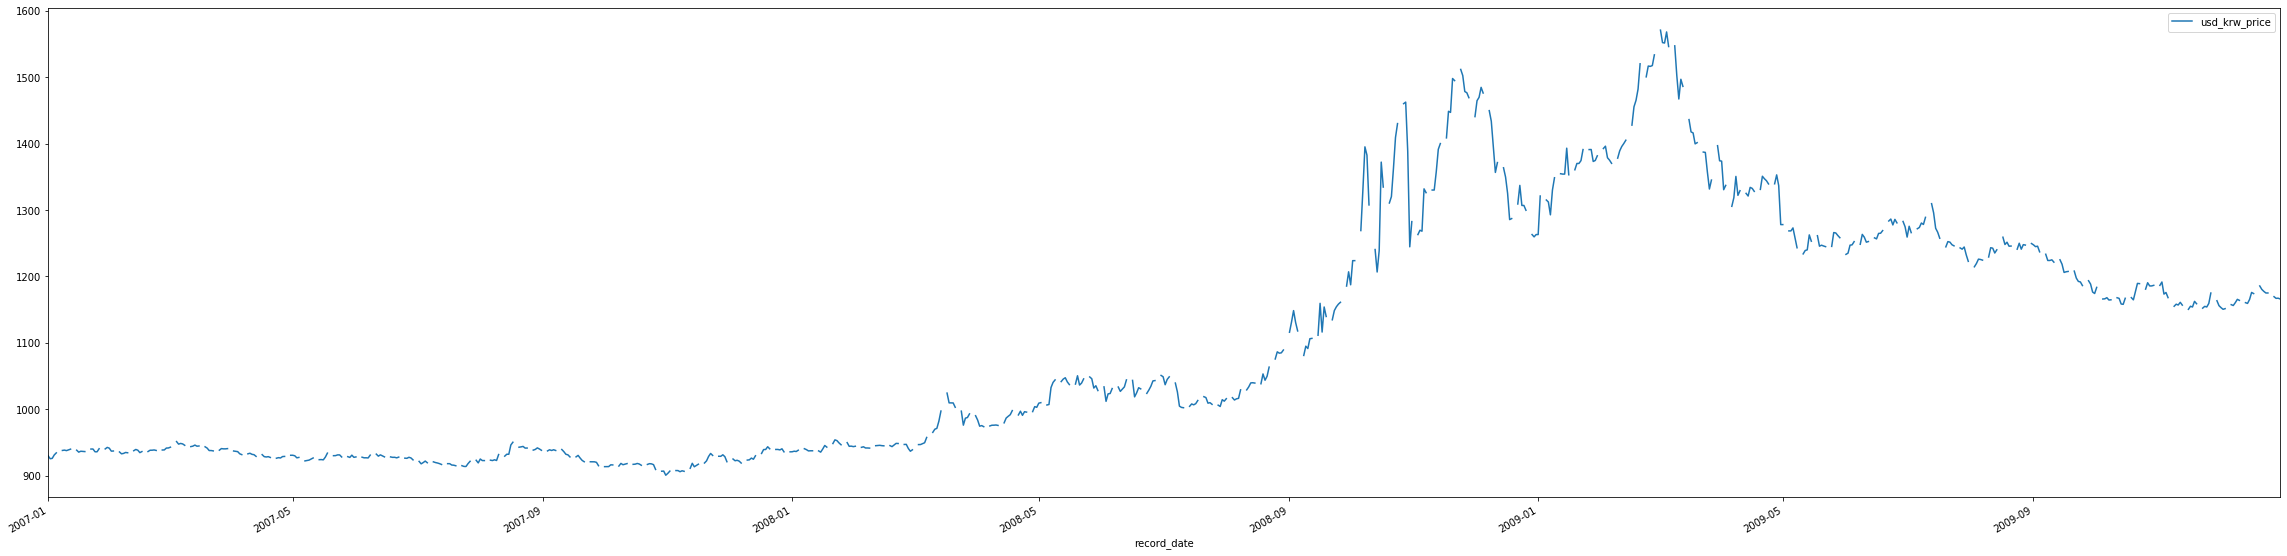

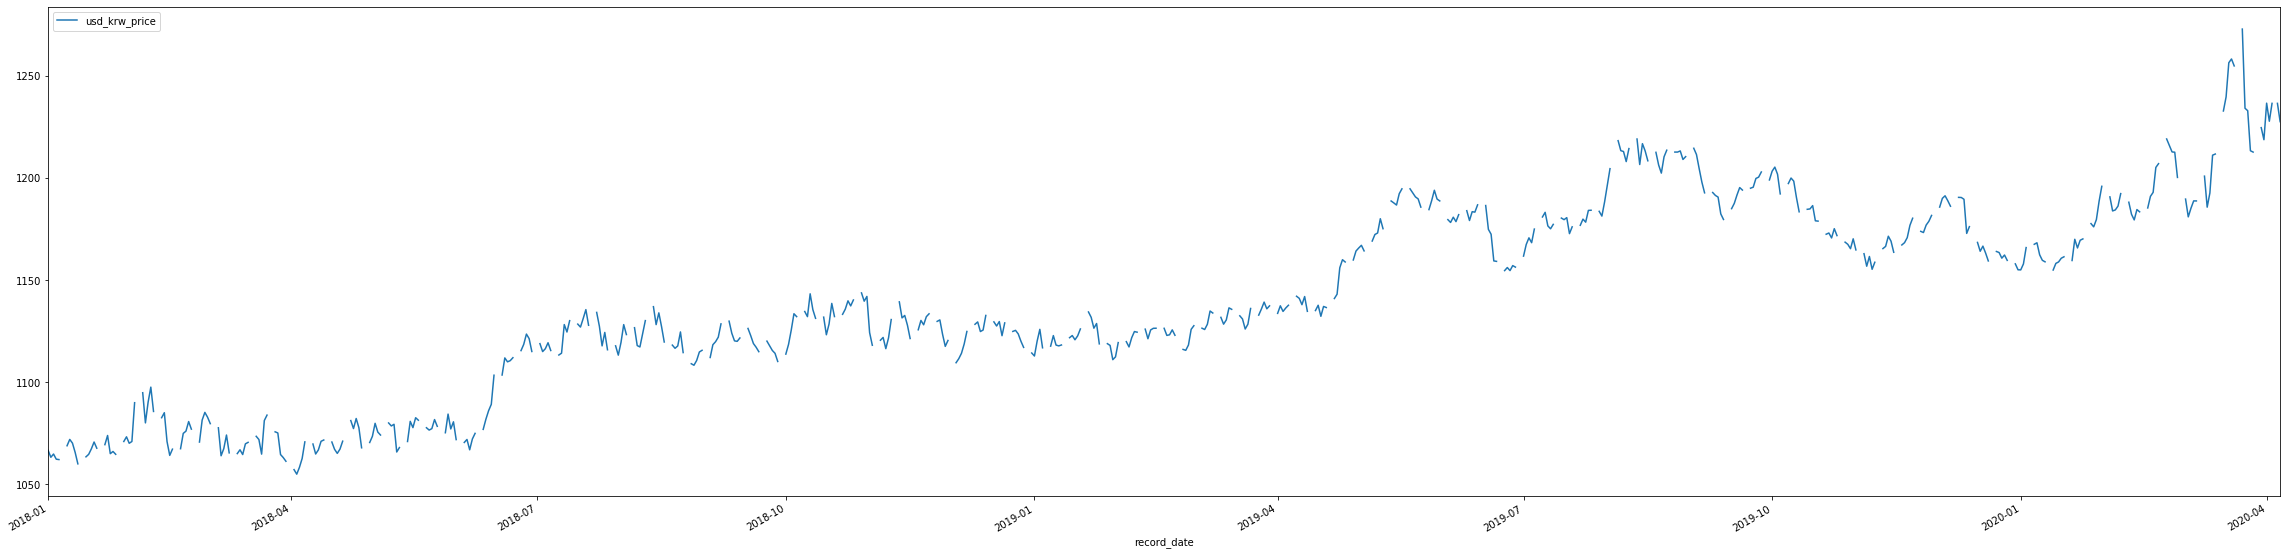

In [6]:
plot(df, ['usd_krw_price'], list(range(1980, 2020)), lines = [800, 900, 1000, 1100, 1200])
plot(df, ['usd_krw_price'], [1996, 1997, 1998])
plot(df, ['usd_krw_price'], [2007, 2008, 2009])
plot(df, ['usd_krw_price'], [2018, 2019, 2020])


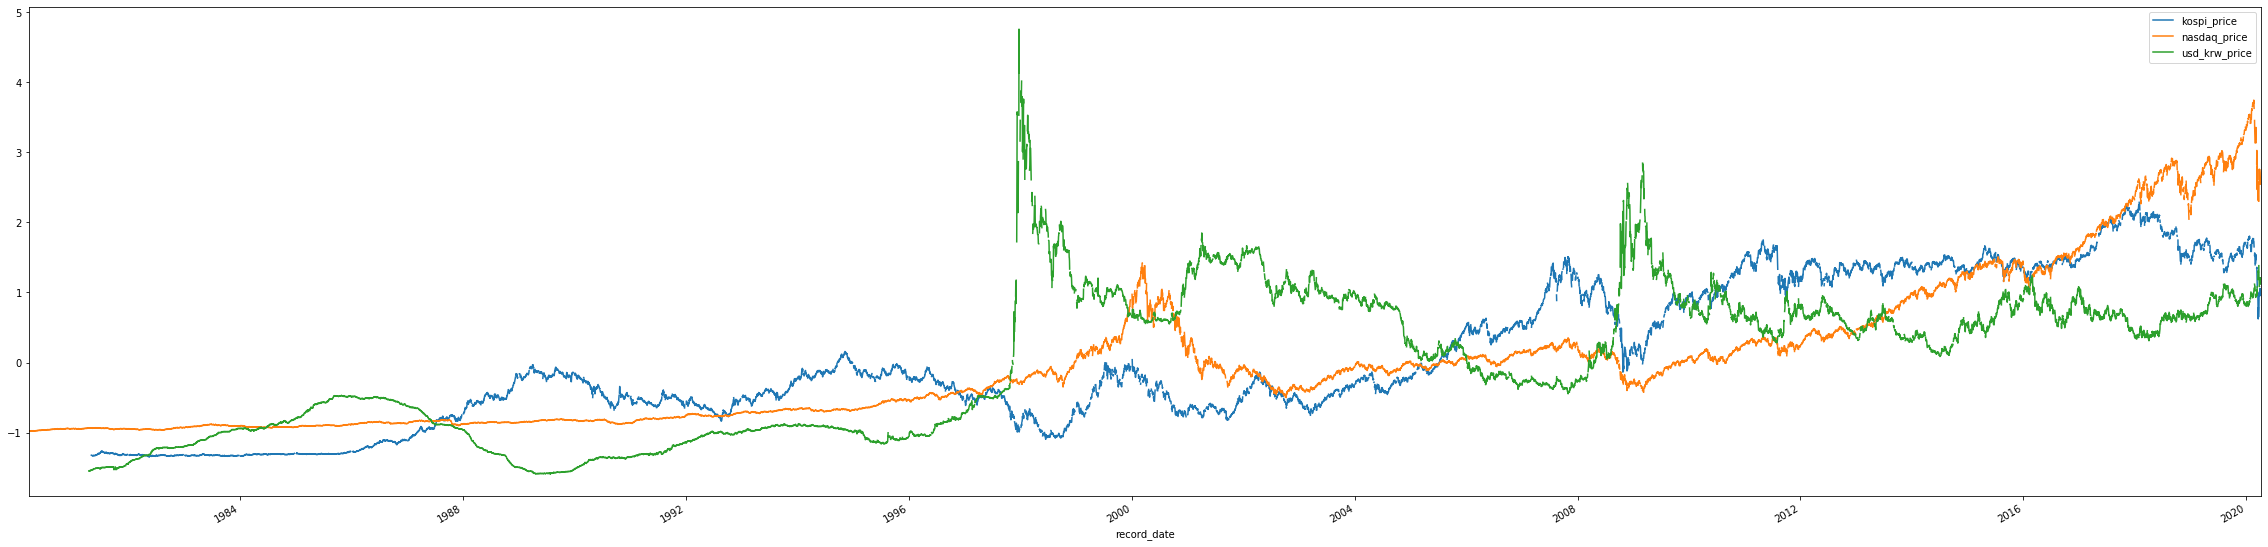

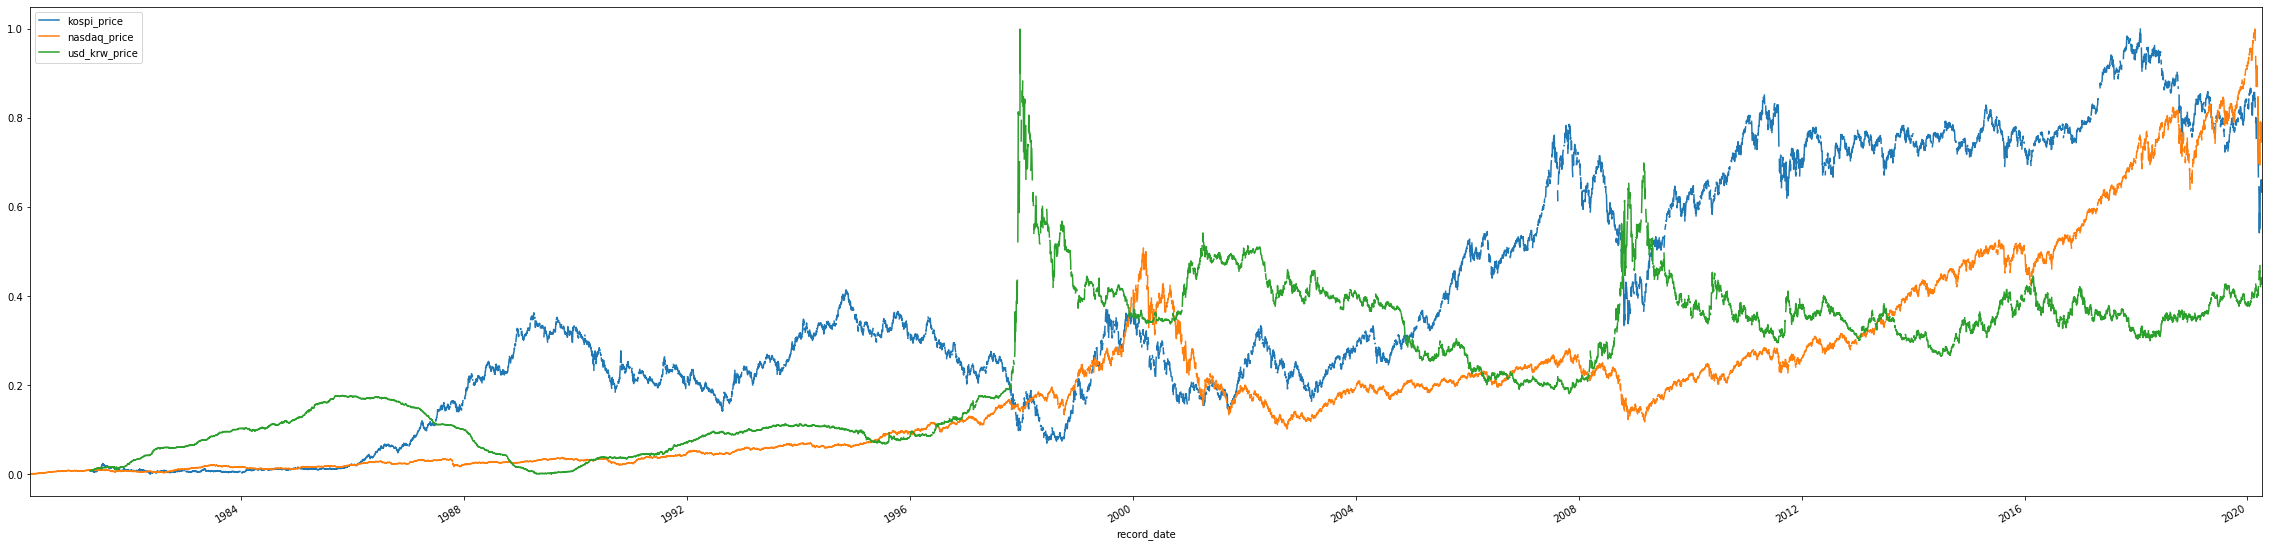

In [7]:
plot(df, ['kospi_price', 'nasdaq_price', 'usd_krw_price'], list(range(1980, 2021)), normalize = True)
plot(df, ['kospi_price', 'nasdaq_price', 'usd_krw_price'], list(range(1980, 2021)), minmax = True)


#plot(df, ['kospi_price', 'nasdaq_price', 'usd_krw_price'], list(range(1997, 1999)), normalize = True)
#plot(df, ['kospi_price', 'nasdaq_price', 'usd_krw_price'], list(range(2008, 2010)), normalize = True)
#plot(df, ['kospi_price', 'nasdaq_price', 'usd_krw_price'], list(range(2019, 2021)), normalize = True)

### 첫번째 궁금증) 유가와 KOSPI 주가는 어떤 관계를 갖는가?

→전체 기간으로 보았을 때는 거의 관계가 없다.(매우 약한 양의 상관관계) 어느정도 비슷한 추이를 보이지만, 영향을 받지 않을 때도 있다. corr : 0.023
하지만! 구간을 나누어 보았을때는 확실히 차이가 보인다! 월별로 봤을 때는 차이 없음, 년도별로 보기!

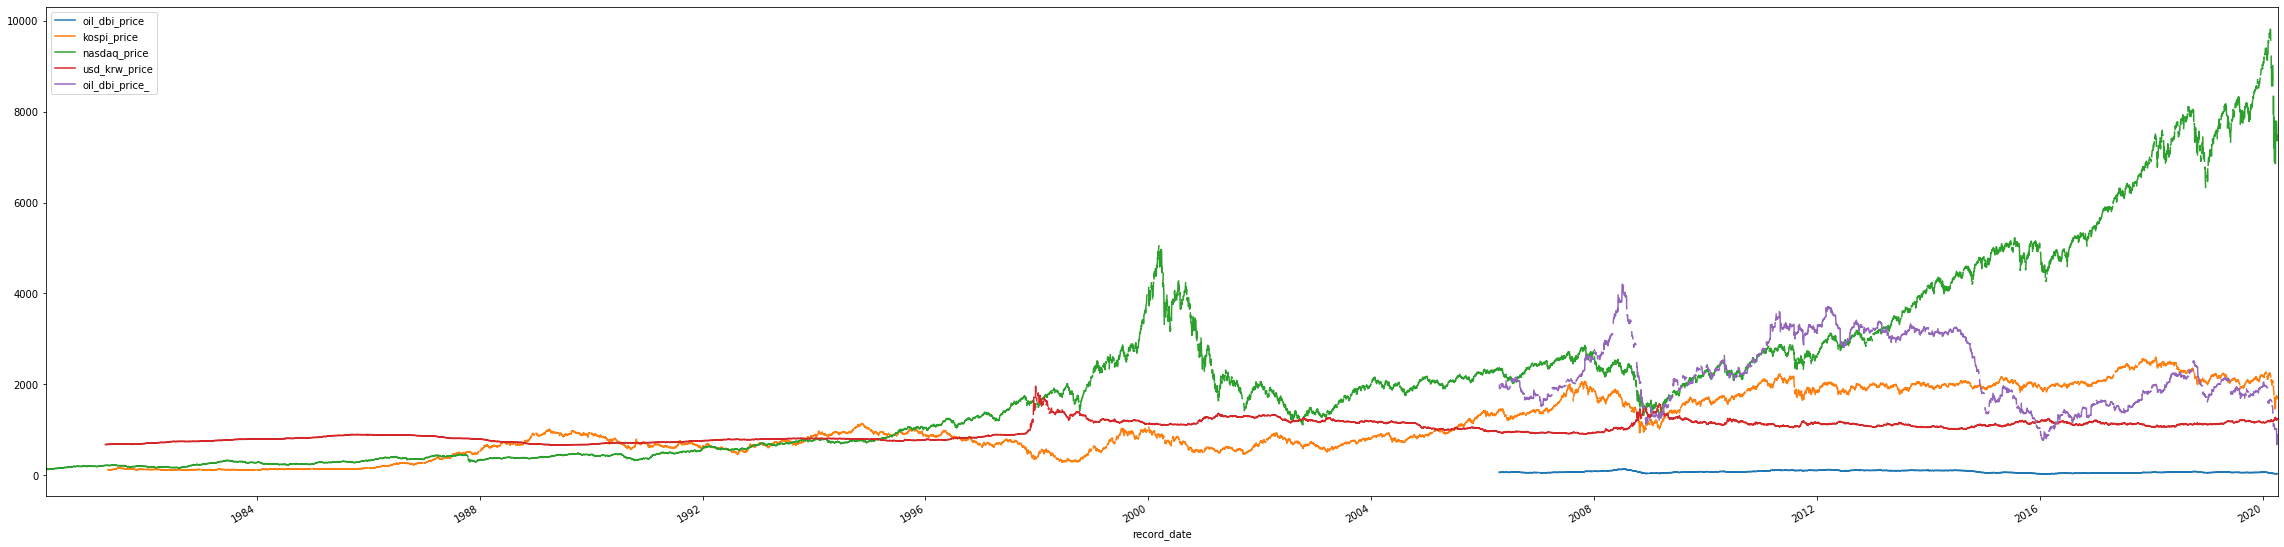

                oil_dbi_price  kospi_price  nasdaq_price  usd_krw_price  \
oil_dbi_price        1.000000     0.030360     -0.368685      -0.287620   
kospi_price          0.030360     1.000000      0.818628       0.429277   
nasdaq_price        -0.368685     0.818628      1.000000       0.562179   
usd_krw_price       -0.287620     0.429277      0.562179       1.000000   
oil_dbi_price_       1.000000     0.030360     -0.368685      -0.287620   

                oil_dbi_price_  
oil_dbi_price         1.000000  
kospi_price           0.030360  
nasdaq_price         -0.368685  
usd_krw_price        -0.287620  
oil_dbi_price_        1.000000  


In [8]:
df.plot()
plt.show()
print(df.corr())

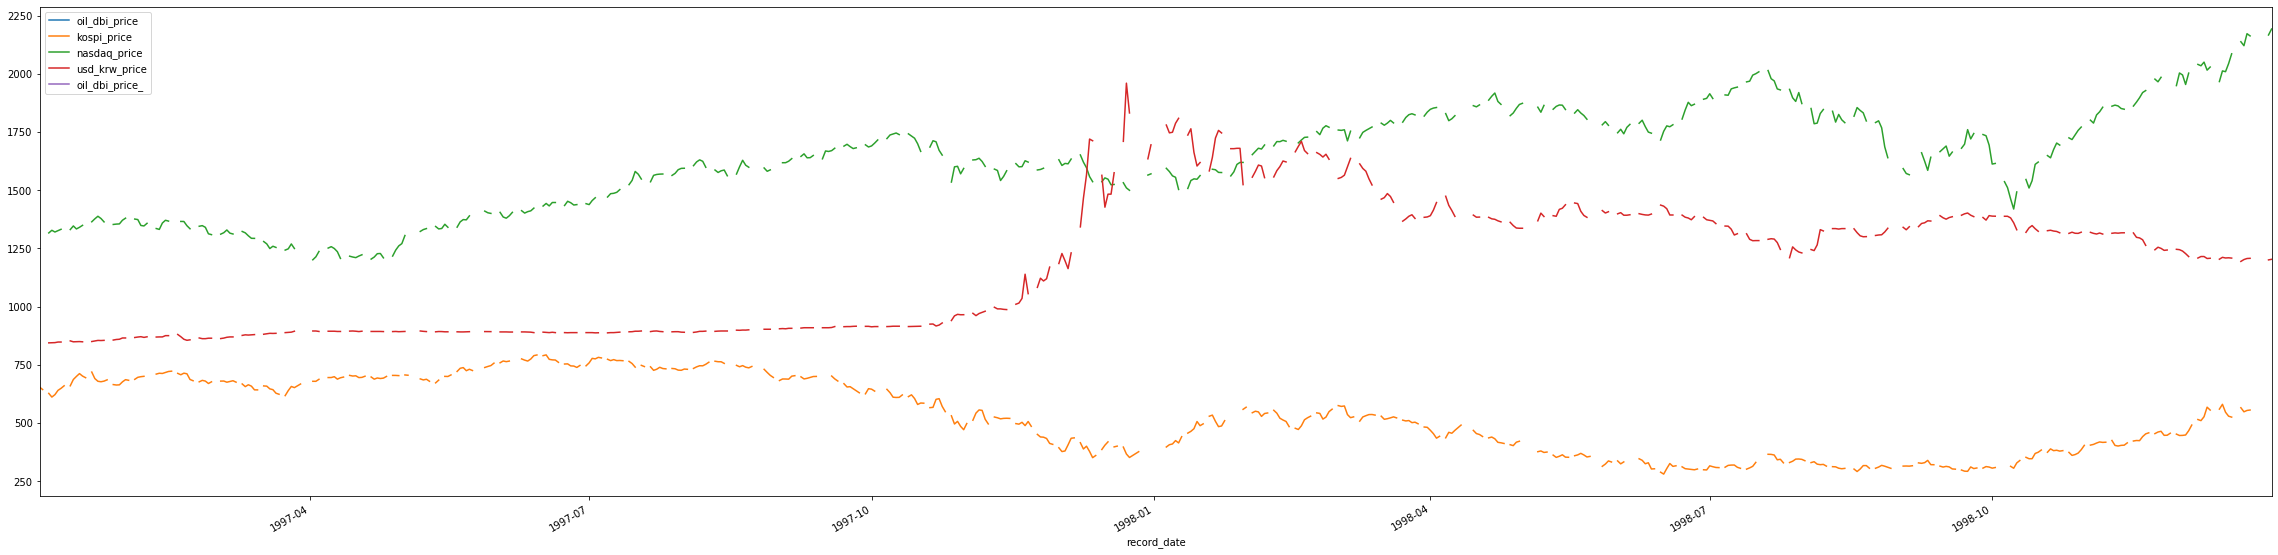

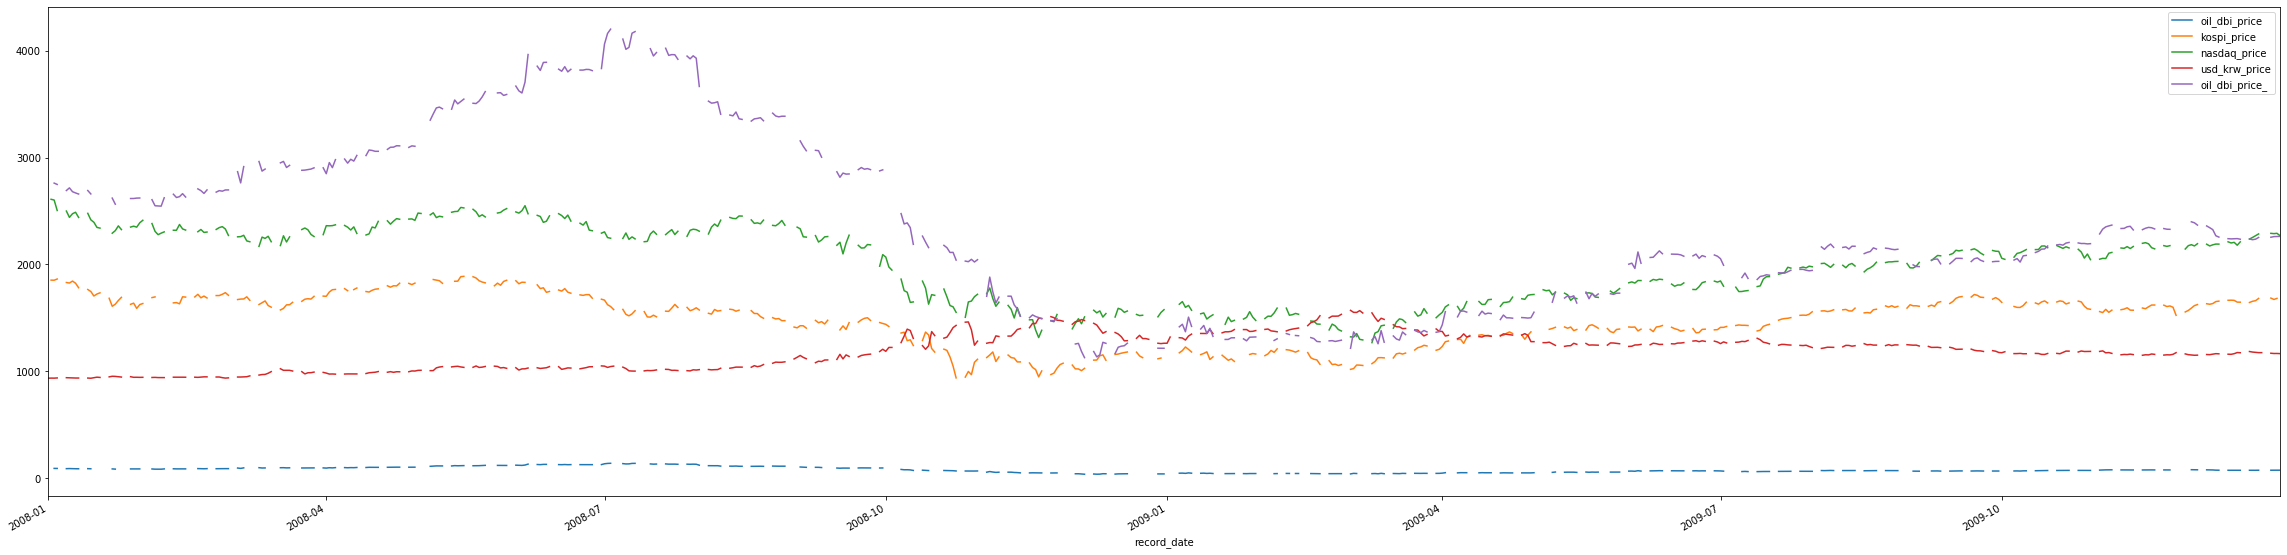

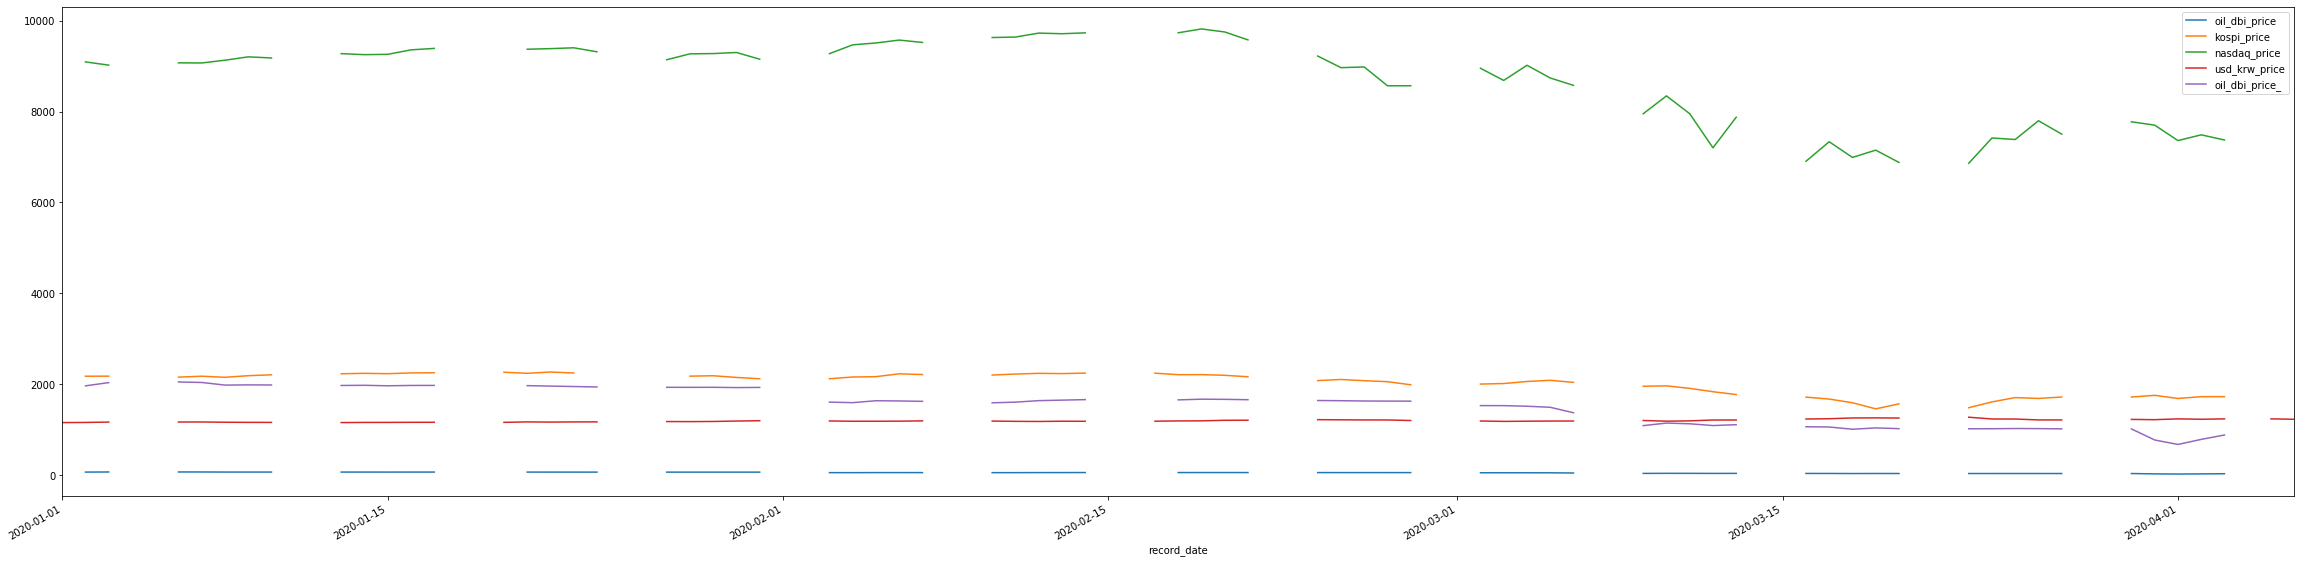

In [9]:

df_fall_97 = df[df.index.year.isin([1997, 1998])]
df_fall_08 = df[df.index.year.isin([2008, 2009])]
df_fall_20 = df[df.index.year.isin([2020])]
df_fall_97.plot()
plt.show()
df_fall_08.plot()
plt.show()
df_fall_20.plot()
plt.show()


### 한국 주식 시장(KOSPI)는 마치 틀에 갇혀있는 것처럼 일정 수준의 주가를 유지하기 때문에 박스피라고 불린다. 그렇다면 박스권 안에서 어떤 주식은 성장하고 어떤 주식은 떨어졌을까?

In [20]:
df_company = []
df_kospi = []
df_finance = []

connection = pymysql.connect(host='localhost',
                             user='investment',
                             password='1111',
                             db='investment',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

with connection.cursor() as cursor:
    sql = '''SELECT *
                FROM company c;'''
    cursor.execute(sql)
    df_company = pd.DataFrame(cursor.fetchall())
    
    sql = '''SELECT record_date, company_id, closing_price
                FROM companydailystockdata;'''
    cursor.execute(sql)
    df_kospi = pd.DataFrame(cursor.fetchall())
    
    sql = '''SELECT record_date, kospi_price
                FROM dailyfinancedata d
                WHERE d.kospi_price is not null;'''
    cursor.execute(sql)
    df_finance = pd.DataFrame(cursor.fetchall())
    
connection.close()

In [9]:
df_kospi = df_kospi.set_index('record_date')
df_finance = df_finance.set_index('record_date')

In [10]:

df_kospi['company_id'] = df_kospi['company_id'].astype(int)
df_finance = df_finance.astype(float)
print(df_company.head())
print(df_kospi.head())
print(df_finance.head())

     id   name    code                             sector  \
0  6016    DSR  155660                        1차 비철금속 제조업   
1  6017  GS글로벌  001250                          상품 종합 도매업   
2  6018  HSD엔진  082740                      일반 목적용 기계 제조업   
3  6019  LG이노텍  011070                           전자부품 제조업   
4  6020   LS산전  010120  전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업   

                                            industry     update_datetime  
0                                             합섬섬유로프 2020-03-02 02:27:15  
1  수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서... 2020-03-02 02:27:15  
2                                     대형선박용엔진,내연발전엔진 2020-03-02 02:27:15  
3                                        기타 전자부품 제조업 2020-03-02 02:27:15  
4  고압기기,저압기기,변압기,배전반,PLC,인버터,빌딩설비,공조기,건축배관,자동화기기 ... 2020-03-02 02:27:15  
             company_id  closing_price
record_date                           
1996-04-25         6351           3896
1996-04-26         6351           3974
1996-04-27         6351    

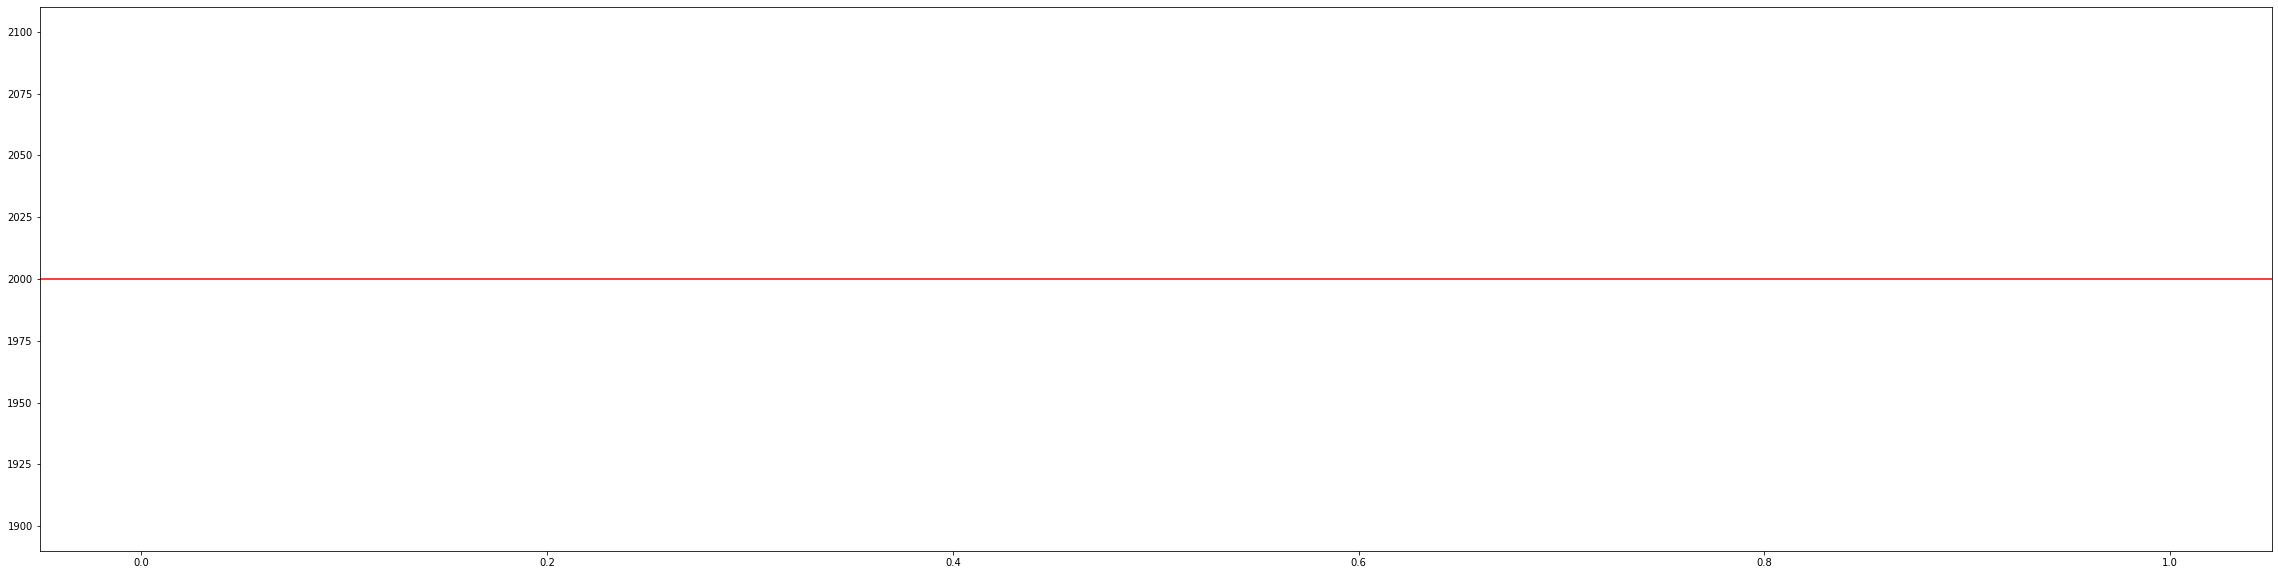

In [14]:
plt.plot(df_finance)
plt.axhline(y=2000, color='r', linestyle='-')
plt.rcParams["figure.figsize"] = (60,10)
plt.show()


## 우량기업 찾아내기

In [18]:
## 우량기업 기준 : 자본 1000억 이상, 부채비율 100% 미만, 유동비율 150% 이상, 유보율 500% 이상
## 성장기업 : 매출이 평균 5% 이상 상승

In [23]:
sql = '''SELECT * from financial_statement fs
            JOIN company c
            ON fs.company_id = c.id;'''
connection = pymysql.connect(host='localhost',
                             user='investment',
                             password='1111',
                             db='investment',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
fn_st = []
with connection.cursor() as cursor:
    cursor.execute(sql)
    fn_st = pd.DataFrame(cursor.fetchall())

fn_st.head()
    

,id,company_id,update_date,year,sales,operating_income,net_income,asset,liability,capital,...,dividend_yield,dividend_payout,issued_stocks,dps,c.id,name,code,sector,industry,update_datetime
0,357,6351,None,2015,2232,48,56,3172,871,2301,...,0.98,39.46,27931470,80,6351,동화약품,000020,의약품 제조업,"의약품 제조,판매,수출입",2020-03-02 02:27:15
1,358,6351,None,2016,2375,113,263,3246,717,2529,...,1.35,11.59,27931470,110,6351,동화약품,000020,의약품 제조업,"의약품 제조,판매,수출입",2020-03-02 02:27:15
2,359,6351,None,2017,2589,110,470,3672,703,2969,...,1.54,8.81,27931470,150,6351,동화약품,000020,의약품 제조업,"의약품 제조,판매,수출입",2020-03-02 02:27:15
3,360,6351,None,2018,3066,112,101,3706,732,2971,...,1.32,32.90,27931470,120,6351,동화약품,000020,의약품 제조업,"의약품 제조,판매,수출입",2020-03-02 02:27:15
4,361,6351,None,2019,3072,99,94,3760,752,3009,...,1.44,35.24,27931470,120,6351,동화약품,000020,의약품 제조업,"의약품 제조,판매,수출입",2020-03-02 02:27:15


In [26]:
%store -r name_list

In [76]:
import itertools
id_set = (set(fn_st['company_id']))
count = 0
for id in id_set:
    
    fn_st_comp = fn_st[fn_st['company_id'] == id]
    year_list = fn_st_comp['year']
    fn_st_comp = fn_st_comp[fn_st_comp.columns[:2].tolist() + fn_st_comp.columns[3:-1].tolist()]
    print(fn_st_comp.to_string())
    
    break
        
    

        id  company_id  year  sales  operating_income  net_income  asset  liability  capital  capital_stock  operating_cashflow  investment_cashflow  financial_cashflow  capex  fcf  Interest_liability operating_margin net_margin    roe    roa debt_ratio capital_reserve_rate   eps    per   bps   pbr dividend_yield dividend_payout  issued_stocks  dps  c.id name    code    sector                    industry
2106  2463        6144  2015   2596               101          83   2257       1084     1172            269                 106                  -36                 -72     39   66                 277             3.89       3.19   7.30   3.67      92.50               339.84   183  20.30  2648  1.40           0.94           18.71       45282310   35  6144   대현  016090  봉제의복 제조업  여성의류 및 악세사리류 제조,도매,유통(백화점)
2107  2464        6144  2016   2802               161         469   2497        871     1626            269                 100                  330                -292     46   54    

TypeError: unsupported operand type(s) for -: 'str' and 'str'